In [1]:
import numpy as np
from matplotlib import use
import matplotlib.pyplot as plt

from nmrnet import *
from nmrdataset import *
from nmrgen import generateRandomSpectrum

import torch as th
from torch import Tensor
from torch.utils.data import DataLoader
from safetensors.torch import load_model
from torchinfo import summary

from sklearn.metrics import precision_recall_curve, f1_score

import ipympl
from ipywidgets import interact, FloatSlider, BoundedIntText

from tqdm.notebook import trange, tqdm

In [2]:
use("inline")
yy, (res, _) = generateRandomSpectrum(0)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(yy["filtered"])
ax.scatter(res,[yy["filtered"][i] for i in res], c = "orange", zorder = 10);

In [3]:
ML = 10000
ML_test = 1000
batch_size = 1
train_set_narrow = NMRDataset(maxLen = ML     , mode = "narrow")
train_set_wide   = NMRDataset(maxLen = ML     , mode = "wide"  )
test_set_narrow  = NMRDataset(maxLen = ML_test, mode = "narrow", startSeed = ML)
test_set_wide    = NMRDataset(maxLen = ML_test, mode = "wide"  , startSeed = ML)

train_loader_narrow: DataLoader = DataLoader(
    dataset=train_set_narrow, batch_size=batch_size, shuffle=False,
    num_workers=2
)
train_loader_wide: DataLoader = DataLoader(
    dataset=train_set_wide  , batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader_narrow: DataLoader = DataLoader(
    dataset=test_set_narrow ,  batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader_wide: DataLoader = DataLoader(
    dataset=test_set_wide   ,  batch_size=batch_size, shuffle=False,
    num_workers=2
)

In [4]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
modelnarrow = NMRNet().to(device)
modelwide = NMRNet().to(device)
print(summary(modelnarrow, input_size=(32, nmr.nPts)))

Layer (type:depth-idx)                   Output Shape              Param #
NMRNet                                   [32, 1, 1024]             --
├─Inception: 1-1                         [32, 136, 1024]           --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [32, 16, 1024]            51
│    │    └─Sequential: 3-2              [32, 32, 1024]            165
│    │    └─Sequential: 3-3              [32, 64, 1024]            585
│    │    └─Sequential: 3-4              [32, 16, 1024]            561
│    │    └─Sequential: 3-5              [32, 8, 1024]             585
├─Conv1d: 1-2                            [32, 64, 1024]            8,768
├─Conv1d: 1-3                            [32, 32, 1024]            2,080
├─LSTM: 1-4                              [32, 1024, 32]            6,400
├─Conv1d: 1-5                            [32, 32, 1024]            1,056
├─Conv1d: 1-6                            [32, 16, 1024]            52

In [5]:
load_model(modelnarrow, f"./narrow/modelpars_narrow_final.safetensors")
load_model(modelwide, f"./wide/modelpars_wide_final.safetensors")
th.no_grad();

interactive(children=(BoundedIntText(value=4, description='Sp. No:', max=999), FloatSlider(value=0.5, descript…

<IPython.core.display.Javascript object>


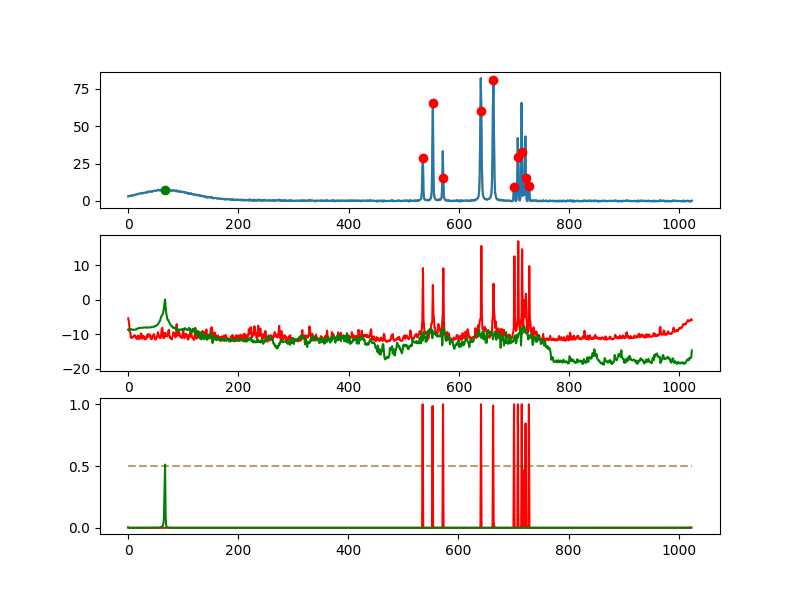

In [10]:
use("notebook")
threshold_slider_narrow = FloatSlider(
    min=0.0,
    max=1,
    step=0.01,
    description='Threshold (narrow):',
    value = 0.5,
    continuous_update=True,
    style={'description_width': 'initial'}
)

threshold_slider_wide = FloatSlider(
    min=0.0,
    max=1,
    step=0.01,
    description='Threshold (wide):',
    value = 0.5,
    continuous_update=True,
    style={'description_width': 'initial'}
)

spec = BoundedIntText(
    value=4,
    min=0,
    max=ML_test - 1,
    step=1,
    description='Sp. No:'
)

fig, ax = plt.subplots(3,1,figsize=(8, 6))

def update(idx = 4, n = 0.5, w = 0.5):
    x_a, _ = test_set_narrow[idx]
    x_a = x_a.unsqueeze(0)
    
    targetnarrow = modelnarrow(x_a)
    knarrow = targetnarrow.detach().cpu().numpy()[0][0]
    sigknarrow = th.special.expit(targetnarrow).cpu().detach().numpy()[0][0]

    targetwide = modelwide(x_a)
    kwide = targetwide.detach().cpu().numpy()[0][0]
    sigkwide = th.sigmoid(targetwide).cpu().detach().numpy()[0][0]

    x_a = x_a.cpu()[0]
    
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    
    ax[0].plot(x_a, color = "orange")
    
    ax[1].plot(knarrow.T, color = "red")
    ax[1].plot(kwide.T, color = "green")
    
    ax[2].plot(sigknarrow.T, color = "red")
    ax[2].plot(sigkwide.T, color = "green")
    ax[2].hlines(n, 0, 1024, linestyles = "dashed", color = "red"  , alpha = 0.3)
    ax[2].hlines(w, 0, 1024, linestyles = "dashed", color = "green", alpha = 0.3)

    
    indicesnarrow = np.nonzero(sigknarrow > n)
    indiceswide = np.nonzero(sigkwide > w)
    print(n,w)
    ax[0].plot(x_a)
    ax[0].scatter(indicesnarrow, x_a[indicesnarrow], zorder = 10, color = "red")
    ax[0].scatter(indiceswide, x_a[indiceswide], zorder = 10, color = "green")

interact(update,
         idx = spec,
         w=threshold_slider_wide, n=threshold_slider_narrow);

fig.show()
# No: 4

In [7]:
use("inline")
fig, ax = plt.subplots(1,2,figsize=(8, 4))

fig.suptitle("Loss during training\nNarrow - Wide\n")

trainerr = np.loadtxt(f"./narrow/trainlosses.csv", delimiter = ",", dtype = float)
testerr  = np.loadtxt(f"./narrow/testlosses.csv",  delimiter = ",", dtype = float)
ax[0].plot(trainerr, label = "Training")
ax[0].plot(testerr , label = "Test"    )
ax[0].legend()

trainerr = np.loadtxt(f"./wide/trainlosses.csv", delimiter = ",", dtype = float)
testerr  = np.loadtxt(f"./wide/testlosses.csv",  delimiter = ",", dtype = float)
ax[1].plot(trainerr, label = "Training")
ax[1].plot(testerr , label = "Test"    )
ax[1].legend()

fig.show()

In [12]:
all_targets_narrow = []
all_targets_wide   = []
all_outputs_prob_narrow = []
all_outputs_prob_wide   = []


with th.no_grad():
    for inputs, targets in tqdm(test_loader_narrow):
        
        inputs = inputs.to(device)
        
        outputs_prob_narrow = th.sigmoid(modelnarrow(inputs))
        all_outputs_prob_narrow.append(outputs_prob_narrow.cpu().numpy().flatten())
        
        all_targets_narrow.append(targets.cpu().numpy().flatten())
    
    
    for inputs, targets in tqdm(test_loader_wide):
        
        inputs = inputs.to(device)
        
        outputs_prob_wide   = th.sigmoid(modelwide(inputs)  )        
        all_outputs_prob_wide  .append(outputs_prob_wide  .cpu().numpy().flatten())
        
        all_targets_wide  .append(targets.cpu().numpy().flatten())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
y_true_narrow = np.concatenate(all_targets_narrow)
y_true_wide   = np.concatenate(all_targets_wide  )
y_scores_narrow = np.concatenate(all_outputs_prob_narrow)
y_scores_wide   = np.concatenate(all_outputs_prob_wide  )

In [15]:
use("inline")
precision_narrow, recall_narrow, thresholds_narrow = precision_recall_curve(y_true_narrow, y_scores_narrow)
precision_wide  , recall_wide  , thresholds_wide   = precision_recall_curve(y_true_wide  , y_scores_wide  )

epsilon = 1e-7
f1_scores_narrow = (2 * (precision_narrow * recall_narrow) / (precision_narrow + recall_narrow + epsilon))[:-1]
f1_scores_wide   = (2 * (precision_wide   * recall_wide  ) / (precision_wide   + recall_wide   + epsilon))[:-1]

# Max f1
best_f1_idx_narrow = np.argmax(f1_scores_narrow)
best_f1_idx_wide   = np.argmax(f1_scores_wide  )

best_f1_narrow = f1_scores_narrow[best_f1_idx_narrow]
best_f1_wide   = f1_scores_wide  [best_f1_idx_wide  ]

best_threshold_narrow = thresholds_narrow[best_f1_idx_narrow]
best_threshold_wide   = thresholds_wide  [best_f1_idx_wide  ]

best_precision_narrow = precision_narrow[best_f1_idx_narrow]
best_precision_wide   = precision_wide  [best_f1_idx_wide  ]

best_recall_narrow = recall_narrow[best_f1_idx_narrow]
best_recall_wide   = recall_wide  [best_f1_idx_wide  ]

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(recall_narrow, precision_narrow, label='Precision-Recall Curve (narrow)')
ax.plot(recall_wide  , precision_wide  , label='Precision-Recall Curve (wide)')

ax.scatter(best_recall_narrow, best_precision_narrow, marker='o', color='red'  , s=100, zorder=10,
            label=f'Best F1 (Thresh={best_threshold_narrow:.2f}, F1={best_f1_narrow:.2f})')

ax.scatter(best_recall_wide  , best_precision_wide  , marker='o', color='green', s=100, zorder=10,
            label=f'Best F1 (Thresh={best_threshold_wide  :.2f}, F1={best_f1_wide  :.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid(True)
fig.show()